This notebook contains different methods to detection of watermarked pivot statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
from typing import List, Tuple, Union

In [2]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

root_output_path = "../data/output"

# load the datasets you want to load
fname = "data_inverse_n500_facebook_opt13b.json"
data = read_json(os.path.join(root_output_path, fname))
true_intervals = [
    (start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked'
]
vocab_size = data['configuration']['vocab_size']


print(f"True intervals:") 
print(true_intervals)
print("\nConfiguration")
data['configuration']

True intervals:
[(100, 200), (400, 450)]

Configuration


{'model_name': 'facebook/opt-1.3b',
 'intervals': [[0, 100, 'unwatermarked'],
  [100, 200, 'inverse'],
  [200, 400, 'unwatermarked'],
  [400, 450, 'inverse'],
  [450, 500, 'unwatermarked']],
 'prompt_tokens': 50,
 'out_tokens': 500,
 'vocab_size': 50272}

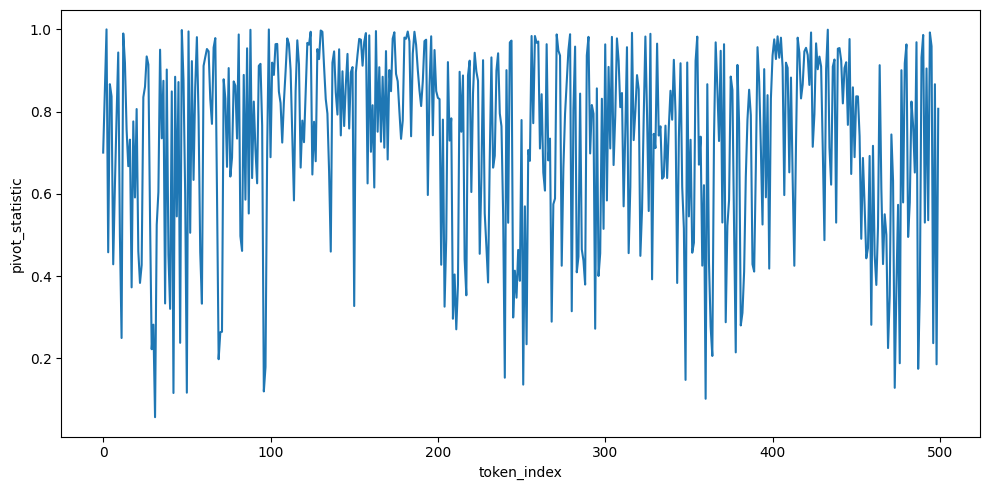

In [3]:
# sample plot for sanity testing
df = []
for sample_index, sample_data in enumerate(data["data"]):
    pivots = sample_data["pivots"]
    for token_index, pivot in enumerate(pivots):
        df.append({
            "sample_index": sample_index,
            "token_index": token_index,
            "pivot_statistic": pivot
        })

df = pd.DataFrame(df)
agg_df = df.groupby(by = ['token_index'])[['pivot_statistic']].mean().reset_index() # plot the pivot statistic

plt.figure(figsize=(10, 5))
sns.lineplot(data=df.loc[df['sample_index'] == 0], # put agg_df in case of agg plot
             # agg_df,
             x='token_index', y='pivot_statistic')
plt.tight_layout()
plt.show()

## Some Utility Functions

In [8]:
# distribution under null, returns numpy array in the given shape
def null_distn_gumbel(shape):
    unif_noise = np.random.rand(*shape)
    return -np.log(1 - unif_noise)

def null_distn_inverse(shape):
    unif_noise = np.random.rand(*shape)
    pi_wt = np.random.randint(vocab_size)
    normalized = pi_wt / (vocab_size - 1)
    return 1 - np.abs((normalized - unif_noise))

In [9]:
# different metrics to track

# metric to find the symmetric differences
def get_symmetric_difference(intA, intB):
  sA, eA = intA
  sB, eB = intB
  return abs(sA - sB) + abs(eA - eB)

def get_summarized_result(get_interval_func):
    metrics_list = []
    interval_endpoints = []
    n = 0
    for sample_index, sample_data in tqdm(list(enumerate(data["data"]))):
        pivots = sample_data["pivots"]
        n = max(n, len(pivots))
        est_intervals = get_interval_func(np.array(pivots))

        # add detected endpoints to array
        for left_end, right_end in est_intervals:
            interval_endpoints.append(left_end)
            interval_endpoints.append(right_end)

        # calculate different metrics for estimated intervals
        metric_row = {}
        small_true_interval = min(true_intervals, key=lambda x: x[1] - x[0])
        large_true_interval = max(true_intervals, key=lambda x: x[1] - x[0])

        if len(est_intervals) == 0:
            # no intervals detected so score is 0
            metric_row["small_score"] = 0
            metric_row["small_score_ratio"] = 0
            metric_row["large_score"] = 0
            metric_row["large_score_ratio"] = 0
        else:
            best_interval = min(est_intervals, key=lambda x: get_symmetric_difference(small_true_interval, x)) # best matching interval
            best_score = get_symmetric_difference(small_true_interval, best_interval)
            metric_row["small_score"] = best_score
            metric_row["small_score_ratio"] = best_score / max(small_true_interval[1] - small_true_interval[0], 1)

            best_interval = min(est_intervals, key=lambda x: get_symmetric_difference(large_true_interval, x)) # best matching interval
            best_score = get_symmetric_difference(large_true_interval, best_interval)
            metric_row["large_score"] = best_score
            metric_row["large_score_ratio"] = best_score / max(large_true_interval[1] - large_true_interval[0], 1)

        metric_row["detected_intervals_count"] = len(est_intervals)
        metric_row["sample_index"] = sample_index

        metrics_list.append(metric_row)

    metric_df = pd.DataFrame(metrics_list)

    # Summary 1: Frequency table of # of detected intervals
    frequency_table = metric_df['detected_intervals_count'].value_counts().reset_index()
    frequency_table.columns = ['value', 'frequency']
    frequency_table = frequency_table.sort_values(by='value')
    frequency_table['proportion'] = frequency_table['frequency'] / frequency_table['frequency'].sum()
    print(f"Frequency Table of Detected Intervals: \n{frequency_table}")

    # Summary 2: Describe the scores
    print(f"\nAdditional Metrics: \n{metric_df[['small_score', 'small_score_ratio', 'large_score', 'large_score_ratio']].describe()}")

    # draw a histogram of detected intervals endpoints
    plt.figure(figsize=(10, 6))
    h = sns.histplot(
        data=pd.DataFrame({'endpoints': interval_endpoints}),
        x='endpoints',
        binwidth=n/100
    )
    plt.vlines(
        x=[int(a) for x in true_intervals for a in x],
        ymin=h.get_ylim()[0],
        ymax = h.get_ylim()[1],
        colors="red"
    )
    plt.title('Histogram of Detected Endpoints')
    plt.xlim(0, n)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Pivot Statistic based Watermark Detection Function

  0%|          | 0/200 [00:00<?, ?it/s]

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      0        142       0.710
1      1         55       0.275
2      2          3       0.015

Additional Metrics: 
       small_score  small_score_ratio  large_score  large_score_ratio
count   200.000000         200.000000    200.00000         200.000000
mean     64.340000           1.286800     94.52000           0.945200
std     175.883282           3.517666    201.66433           2.016643
min       0.000000           0.000000      0.00000           0.000000
25%       0.000000           0.000000      0.00000           0.000000
50%       0.000000           0.000000      0.00000           0.000000
75%       6.000000           0.120000     41.00000           0.410000
max     596.000000          11.920000    554.00000           5.540000


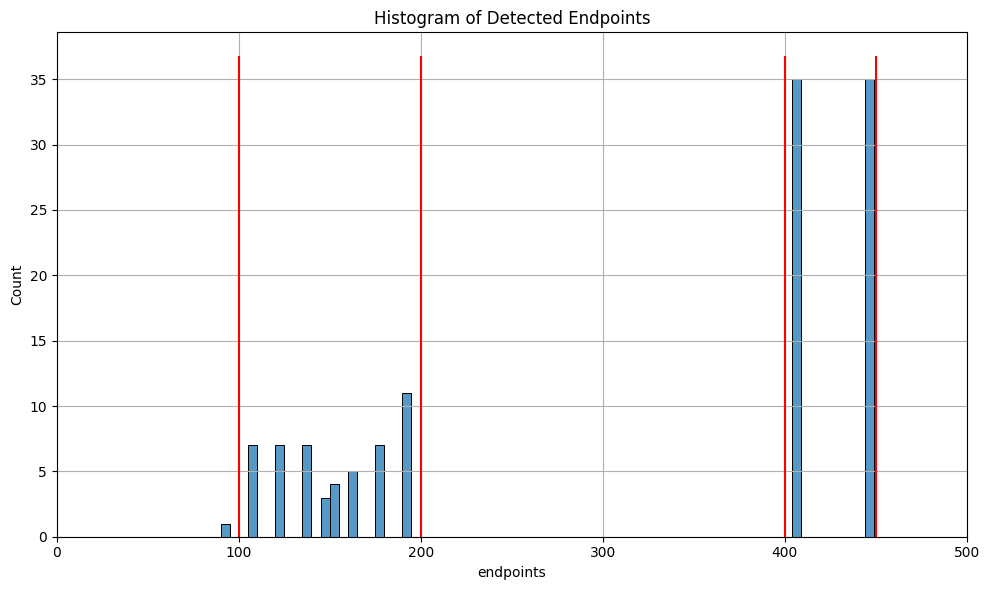

In [10]:
# algorithm to detect the first stage of crude intervals
def get_wm_interval_first_stage(
    pivot_stats: np.ndarray,  # 1D array of pivot statistics
    B=1000,  # number of bootstrap samples
    alpha=0.05,  # significance level
    block_size = None,
    null_distn = null_distn_gumbel,  # distribution under null, returns numpy array in the given shape
    seed = 1234,  # seed for random number generator
    c = 2
):
    assert pivot_stats.ndim == 1, "Pivot statistic should be a 1D array"
    n = pivot_stats.shape[0]
    if block_size is None:
        block_size = np.ceil(n**0.5)
    np.random.seed(seed)

    Bsamples = null_distn((B, n))  # simulate from exact null distn
    M = np.vstack((Bsamples, pivot_stats))  # (B+1) x n

    block_sums = []
    index = 0
    while index < n:
        if index + block_size <= n:
            block_sums.append(M[:, int(index) : int(index + block_size)].sum(axis=1))
            index += block_size  # increase index by block size
        else:
            block_sums.append(
                M[:, int(index) :].sum(axis=1)
            )  # everything else is last block
            break

    block_sums = np.array(
        block_sums
    ).T  # transpose as above operation will make the samples in columns

    pivot_block_sums = block_sums[-1, :]  # take the last row (n/block_size, )
    Vstats = np.abs(block_sums[:-1, :]).max(axis=1)  # this is (B,)
    th = np.quantile(Vstats, q=(1 - alpha))  # find out (1-alpha) quantile

    Ktilde = []
    left_end = None
    right_end = None
    for i in range(pivot_block_sums.shape[0]):
        if pivot_block_sums[i] > th:
            # current block exceeds the threshold, check if it is continuing the current interval
            right_end = i
            if left_end is None:
                left_end = i
        else:
            # current block does not exceed the threshold, so switch over to a new interval
            if left_end is not None:
                Ktilde.append((left_end, right_end))  # add existing block
                left_end = None  # reset
                right_end = None
    if left_end is not None:
        # handle the case where the last block is also over threshold
        Ktilde.append((left_end, right_end))

    # now we convert the major block indices to the minor block indices
    major_intervals = []
    for left_end, right_end in Ktilde:
        # convert left_end, right_end from block_level index to time level index
        left_index = left_end * block_size
        right_index = (right_end + 1) * block_size - 1  # inclusive
        if right_index - left_index + 1 >= c * block_size :
            major_intervals.append((left_index, right_index))

    return major_intervals

# run the detection algorithm to test out
get_summarized_result(
    lambda x: get_wm_interval_first_stage(np.array(x), null_distn=null_distn_inverse, block_size=15, c = 3)
)

  0%|          | 0/200 [00:00<?, ?it/s]

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      0        175       0.875
1      1         23       0.115
2      2          2       0.010

Additional Metrics: 
       small_score  small_score_ratio  large_score  large_score_ratio
count   200.000000         200.000000   200.000000          200.00000
mean     18.545000           0.370900    46.335000            0.46335
std      94.920056           1.898401   148.635985            1.48636
min       0.000000           0.000000     0.000000            0.00000
25%       0.000000           0.000000     0.000000            0.00000
50%       0.000000           0.000000     0.000000            0.00000
75%       0.000000           0.000000     0.000000            0.00000
max     600.000000          12.000000   567.000000            5.67000


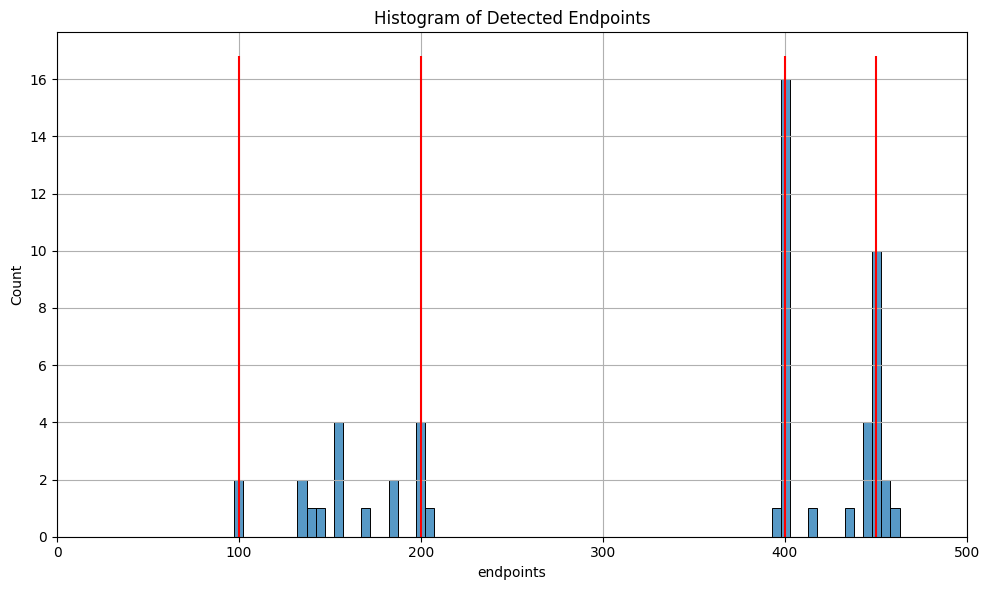

In [11]:
# perform the minor detection
def get_wm_interval_second_stage_rho_adjust(
    pivot_stats: np.ndarray,
    major_intervals: List[Tuple[int, int]],
    null_distn = null_distn_gumbel,
    block_size = None,
    seed = 1234, # seed for random number generator
    mean_under_null = None, # if none, then calculated based on random samples
):
    ########
    # tuning parameters to adjust
    rho = 0.5
    C = 0.1
    gamma = 0.1
    #########

    assert pivot_stats.ndim == 1, "Pivot statistic should be a 1D array"
    n = pivot_stats.shape[0]
    if block_size is None:
        block_size = np.ceil(n**0.5)
    if mean_under_null is None:
        np.random.seed(seed)
        mean_under_null = np.mean(null_distn((10000, )))
    M = pivot_stats - mean_under_null  # subtract mu_0 from all

    # type = 1, is the usually parallelized version of CUSUM
    intervals = []

    # a useful trick is to store cumulative sums, so V[a:b].sum() = Vsum[b] - Vsum[a-1]
    Vsum = M.cumsum()
    for left_end, right_end in major_intervals:
      # get the wiggling indices
      mid = int((left_end + right_end) / 2)  # middle index
      # now tweak by +/- block_size in both direction, without crossover at mid
      left_index_start = int(max(0, left_end - block_size - C * (n**(0.5 + gamma)) ))
      left_index_end = int(min(left_end + block_size, mid - 1))
      right_index_start = int(max(mid, right_end - block_size))
      right_index_end = int(min(right_end + block_size + C * (n**(0.5 + gamma)), n - 1))

      # for each choice (s, t) => find the block average from s to t, and compare against block average outside s, t
      min_m = np.inf
      min_interval = None

      Dj = (Vsum[right_index_end] - Vsum[left_index_start - 1]) if left_index_start >= 1 else Vsum[right_index_end] # this is total block sum
      block_size = (right_index_end - 1) - left_index_start
      dj = Dj / block_size
      
      for i in range(left_index_start, left_index_end + 1):
          for j in range(right_index_start, right_index_end + 1):
              LR_sum = (Vsum[j] - Vsum[i-1]) if i >= 1 else Vsum[j]
              LR_size = max(j - i, 1)
              LR_c_sum = Dj - LR_sum
              LR_c_size = max(block_size - (j - i), 1)
              Mij = LR_c_sum - rho * dj * LR_c_size  # the adjusted CUSUM statistic
              if Mij < min_m:
                  min_interval = (i, j)  # track the interval with max sum
                  min_m = Mij
      if min_interval is not None:
          intervals.append(min_interval)
    return intervals

# run the second stage of the detection (type 1),
def detection_func(pivots):
    block_size = 10
    major_intervals = get_wm_interval_first_stage(np.array(pivots), null_distn = null_distn_inverse, block_size=block_size, c = 3)
    minor_intervals = get_wm_interval_second_stage_rho_adjust(np.array(pivots), major_intervals, null_distn = null_distn_inverse, block_size=block_size)
    return minor_intervals

get_summarized_result(detection_func)

  0%|          | 0/200 [00:00<?, ?it/s]

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      0        175       0.875
1      1         23       0.115
2      2          2       0.010

Additional Metrics: 
       small_score  small_score_ratio  large_score  large_score_ratio
count   200.000000           200.0000     200.0000         200.000000
mean     18.425000             0.3685      46.3550           0.463550
std      94.080017             1.8816     148.7729           1.487729
min       0.000000             0.0000       0.0000           0.000000
25%       0.000000             0.0000       0.0000           0.000000
50%       0.000000             0.0000       0.0000           0.000000
75%       0.000000             0.0000       0.0000           0.000000
max     600.000000            12.0000     561.0000           5.610000


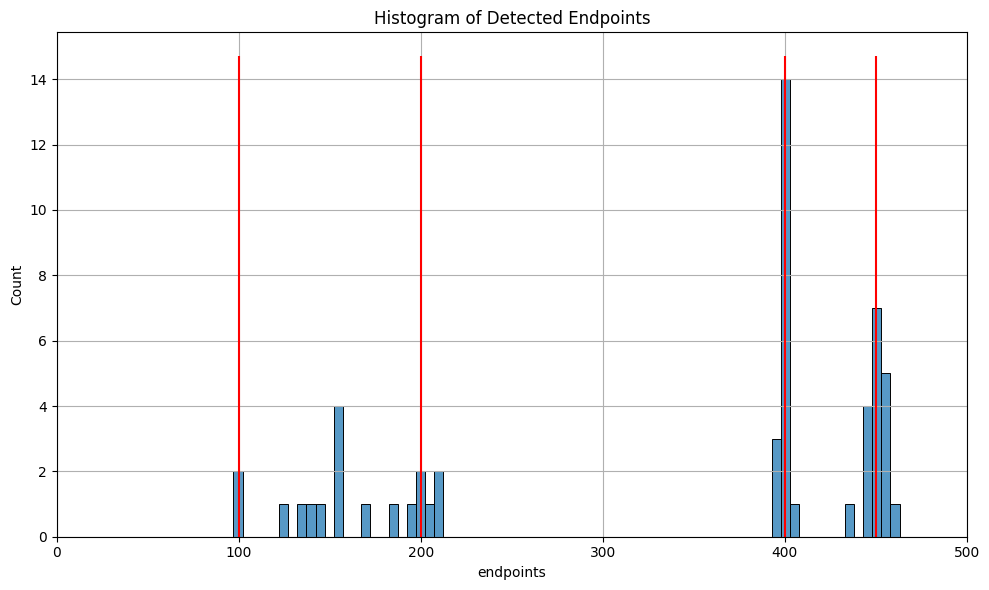

In [14]:
# perform the minor detection
def get_wm_interval_second_stage_rho_adjust_with_extended_sum(
    pivot_stats: np.ndarray,
    major_intervals: List[Tuple[int, int]],
    null_distn = null_distn_gumbel,
    block_size = None,
    seed = 1234, # seed for random number generator
    mean_under_null = None, # if none, then calculated based on random samples
):
    ########
    # tuning parameters to adjust
    rho = 0.5
    C = 0.1
    gamma = 0.1
    #########

    assert pivot_stats.ndim == 1, "Pivot statistic should be a 1D array"
    n = pivot_stats.shape[0]
    if block_size is None:
        block_size = np.ceil(n**0.5)
    if mean_under_null is None:
        np.random.seed(seed)
        mean_under_null = np.mean(null_distn((10000, )))
    M = pivot_stats - mean_under_null  # subtract mu_0 from all

    # type = 1, is the usually parallelized version of CUSUM
    intervals = []

    # a useful trick is to store cumulative sums, so V[a:b].sum() = Vsum[b] - Vsum[a-1]
    Vsum = M.cumsum()
    for interval_index in range(len(major_intervals)):
      left_end, right_end = major_intervals[interval_index]
      
      # get the wiggling indices
      mid = int((left_end + right_end) / 2)  # middle index
      # now tweak by +/- block_size in both direction, without crossover at mid
      left_index_start = int(max(0, left_end - block_size - C * (n**(0.5 + gamma)) ))
      left_index_end = int(min(left_end + block_size, mid - 1))
      right_index_start = int(max(mid, right_end - block_size))
      right_index_end = int(min(right_end + block_size + C * (n**(0.5 + gamma)), n - 1))

      # for each choice (s, t) => find the block average from s to t, and compare against block average outside s, t
      min_m = np.inf
      min_interval = None

      Dj = (Vsum[right_index_end] - Vsum[left_index_start - 1]) if left_index_start >= 1 else Vsum[right_index_end] # this is total block sum
      block_size = (right_index_end - 1) - left_index_start

      # find extended sum from left block's right padding to right block's left padding
      left_major_block_end = major_intervals[interval_index - 1][1] if interval_index > 1 else 0
      right_major_block_start = major_intervals[interval_index + 1][0] - 1 if (interval_index + 1) < len(major_intervals) else (n-1)
      Dj_extended = (Vsum[right_major_block_start] - Vsum[left_major_block_end - 1]) if left_major_block_end >= 1 else Vsum[right_major_block_start]
      extended_size = (right_major_block_start - 1) - left_major_block_end
      dj_extended = Dj_extended / extended_size

      for i in range(left_index_start, left_index_end + 1):
          for j in range(right_index_start, right_index_end + 1):
              LR_sum = (Vsum[j] - Vsum[i-1]) if i >= 1 else Vsum[j]
              LR_size = max(j - i, 1)
              LR_c_sum = Dj - LR_sum
              LR_c_size = max(block_size - (j - i), 1)
              Mij = LR_c_sum - rho * dj_extended * LR_c_size  # the adjusted CUSUM statistic
              if Mij < min_m:
                  min_interval = (i, j)  # track the interval with max sum
                  min_m = Mij
      if min_interval is not None:
          intervals.append(min_interval)
    return intervals

# run the second stage of the detection (type 1),
def detection_func(pivots):
    block_size = 10
    major_intervals = get_wm_interval_first_stage(np.array(pivots), null_distn = null_distn_inverse, block_size=block_size, c = 3)
    minor_intervals = get_wm_interval_second_stage_rho_adjust_with_extended_sum(np.array(pivots), major_intervals, 
                                                                                null_distn = null_distn_inverse, block_size=block_size)
    return minor_intervals

get_summarized_result(detection_func)